# Dam detection

First iteration of dam detection using Sentinel 2 satellite images and GRanD dam dataset.
The code is inspired by work from a previous [hackathon](https://medium.com/@charlotteweil/can-we-locate-dams-from-space-2a796ac8c04b)


## Initialization 

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from pprint import pprint
from glob import glob
from tensorflow.keras import layers

In [2]:
# Load data paths
train_path = glob('data/training_WaterEdges*.gz')
test_path = glob('data/test_WaterEdges*.gz')

print(train_path, test_path)


['data/8.gz'] []


In [3]:
# Tensorflow parse functions

# Parser function, extracted using a .map function

# In normal applications, I guess you would have a single function that does most of the heavy lifting
# but for illustrative purposes, multiple functions are used.
def parse_tfrecord(example_proto):
    """ The parsing function. 
    Read a serialized example into the structure defined by featuresDict.
    Args:
        example_proto: a serialized Example.
  
    Returns: 
        A tuple of the predictors dictionary and the label, cast to an `int32`.
    """
    featuresDict = {
        'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        #'AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        #'NDVI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'class': tf.io.FixedLenFeature([1], dtype=tf.float32)
    }
    
    parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
    labels = parsed_features.pop('class')
    return parsed_features, tf.cast(labels, tf.int64)
    

def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions
    
    Args:
        example_proto: a serialized example
        
    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        #'AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        #'NDVI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'class': tf.io.FixedLenFeature([1], dtype=tf.float32)
    }
    
    return tf.io.parse_single_example(example_proto, featuresDict)
    
def parse_image_RGB(features):
    ''' Stack individual RGB bands into a N dimensional array
    The RGB bands are still separate 1D arrays in the TFRecords, combine them into a single 3D array
    
    Args:
        features: A dictionary with the features (RGB bands or other channels that need to be concatenated)
    '''
    channels = list(features.values())
    label = features['class']
    img = tf.transpose(tf.squeeze(tf.stack([channels[2], channels[1], channels[0]])))
    return img, label   


def parse_label(features):
    labels = features['class']
    y,_, counts = tf.unique_with_counts(labels)
    return y, counts

In [4]:
# Helper function for images
def stretch_image_colorspace(img):
    img = img.numpy()
    max_val = np.max(img)
    return (img * 255 / max_val).astype(np.uint8)
    

## Data exploration
This section will cover some basic data exploration. The idea is to check whether we can get a handle on the TFRecord format, see how it works, and if the data itself has proper characteristics. Furthermore, we can view several of the images as examples, count the label distribution to make the distinction whether we are dealing with a balanced or imbalanced dataset, and possible view several augmentations.   

We will start by simply loading the dataset and printing some basic information about the records inside of the TFRecord datafile.

In [5]:
# Load the training and testing files
train_data = tf.data.TFRecordDataset(train_path, compression_type='GZIP')
test_data = tf.data.TFRecordDataset(test_path, compression_type='GZIP')

print(train_data)
print(test_data)

<TFRecordDatasetV1 shapes: (), types: tf.string>
<TFRecordDatasetV1 shapes: (), types: tf.string>


In [7]:

# Test the parsing functions
# Test parsing record
parse_example = train_data.map(parse_serialized_example, num_parallel_calls=5)
print(parse_example)
# iterable, but not an iterator
print(next(iter(parse_example)))

<DatasetV1Adapter shapes: {B2: (257, 257), B3: (257, 257), B4: (257, 257), class: (1,)}, types: {B2: tf.float32, B3: tf.float32, B4: tf.float32, class: tf.float32}>
{'B2': <tf.Tensor: id=57, shape=(257, 257), dtype=float32, numpy=
array([[0.126  , 0.1262 , 0.1246 , ..., 0.10965, 0.10965, 0.1077 ],
       [0.1241 , 0.1248 , 0.1251 , ..., 0.1041 , 0.1041 , 0.1053 ],
       [0.1216 , 0.1219 , 0.1228 , ..., 0.10295, 0.10295, 0.1033 ],
       ...,
       [0.09645, 0.09645, 0.0954 , ..., 0.095  , 0.094  , 0.0934 ],
       [0.09715, 0.09715, 0.09605, ..., 0.1023 , 0.1027 , 0.1011 ],
       [0.0964 , 0.0964 , 0.09685, ..., 0.1019 , 0.104  , 0.1061 ]],
      dtype=float32)>, 'B3': <tf.Tensor: id=58, shape=(257, 257), dtype=float32, numpy=
array([[0.1096 , 0.1089 , 0.1112 , ..., 0.09625, 0.09625, 0.09485],
       [0.1103 , 0.1084 , 0.1099 , ..., 0.08885, 0.08885, 0.0907 ],
       [0.1112 , 0.1098 , 0.1099 , ..., 0.08825, 0.08825, 0.08875],
       ...,
       [0.07575, 0.07575, 0.07605, ..., 0.06

The code above first loads the dataset and then we map the dataset using the parse_tfrecord function, which returns a dictionary of keys and tensors. As we can see, we have made a connection to the features B2,B3,B4, and class and each of their tensors (values) into a dictionary. Now we can easily extract and transform features from each example. 

The only thing we need to do now is write a function on how these transformations should look like, which we have already done. All that is left is to execute these functions in a similar way as before.

In [8]:
## Training data files
# image parsing function
parsed_record = train_data.map(parse_serialized_example)
# returns the image and label
parsed_image = parsed_record.map(parse_image_RGB)
# parse just the labels and their counts
parsed_label = parsed_record.map(parse_label)

## Test data files
# image parsing function
parsed_record_test = test_data.map(parse_serialized_example)
# returns the image and label
parsed_image_test = parsed_record_test.map(parse_image_RGB)
# parse just the labels and their counts
parsed_label_test = parsed_record_test.map(parse_label)

The parsed_record variable holds similar information as the parse_example earlier, but this time we specify exactly which features we want to have and which ones we do not, and the labels are also passed into the featuresDict instead of being returned as a separate feature. 

The parsed_image variable holds information on what specific transformation we want to apply to the tensors, which is specified in the parse_image_RGB function. Basically, we stack all the individual arrays together to create a single 3D array with shape (257, 257, 3,) which will be a single image. The label is returned separately. We will use this specific object to visualize example images.

Finally, the parsed_label variable will be used to determine the label distribution. For each instance, it counts which label occurs, which is either 0 or 1, and how many times it occurs. Since we are dealing with single examples, it will return 1 as well. 

### Example patches
We can now visualize some of the data hidden inside of the TFRecords. The way this is done is via the parsed_image variable defined above. From this point onwards, the parsed_image variables acts as an iterable, so we can simply loop over it in a for loop, or we can declare it as an iterator by using the iter() function. We will use the latter.

Example patches from the sentinel 2 satellite (RGB channels only)

In [9]:
num_examples = 5
columns = 5
rows = 2

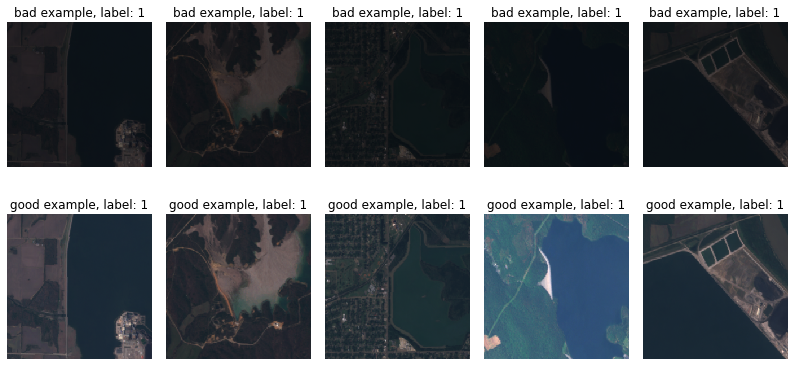

In [10]:
fig = plt.figure(figsize=(columns+8, rows+6))
gs = gridspec.GridSpec(rows, columns,
         wspace=0.1, hspace=0.0, 
         top=1.-0.5/(rows + 1), bottom=0.5/(rows+1), 
         left=0.5/(columns+1), right=1-0.5/(columns+1)) 

parse_iter = iter(parsed_image)
for j in range(columns):
    image_features, label = parse_iter.next()
        
    # bad example: too dark
    ax = plt.subplot(gs[0,j])
    ax.set_title("bad example, label: {}".format(int(label.numpy())))
    ax.imshow(image_features)
    plt.axis('off')
    
    #good example: stretched colorspace
    ax = plt.subplot(gs[1,j])
    ax.set_title("good example, label: {}".format(int(label.numpy())))
    ax.imshow(stretch_image_colorspace(image_features))
    plt.axis('off')

The images above are still somewhat dark, and not satisfactory. Upon inspection of the TFRecord stream in the RGB channels I found that the values were somewhere between 0 and 0.02. Assuming that the color space was mapped in between \[0,1\] for all channels, this is very low, and thus it is no wonder that the images appear dark. 

In order to solve this problem we can force the images to use the entire range of possible pixel values by mapping the color space to \[0,255\] and forcing the highest pixel value to 255 itself. The way we can do this is to simply multiple each element in each color channel by 255, and dividing it by the maximum value (out of all the channels). The function that does this is implemented above in the stretch_image_colorspace function.

The results of implementing this change looks something like what is depicted in the lower tiles

### Label distribution
The label distribution is important for several reasons. The first reason is ofcourse to see whether there is a class imbalance in our training and testing datasets. The second reason is the to see the order in which the classes appear. During training, you want to shuffle the examples in such a way that the classifier sees all classes in a batch in a proportionate fashion. This helps improve training.

In [11]:
# the code state+value reads like a recursion
# the state gets saved and incremented by value (similar to a for loop)
# state by default initializes to 0
# value contains the return argument in the mapped counted labels function
# reduce(np.int64(0), lambda state, value: state + value)
def count_labels(parser):
    cnt = parser.reduce(np.int64(0), lambda x, y: x + y)
    print("total count is {}".format(cnt[1]))
    print("Total number of examples with label 1 is {}".format(cnt[0]))
    
#count_labels(parsed_label)
#cnt = parsed_label.reduce(np.int64(0), lambda x, y: x + y)

iterator = iter(parsed_label)

i = 0
while True:
    i +=1
    try:
        iterator.next()
    except tf.errors.InvalidArgumentError:
        print("found error at iteration {}".format(i))
        continue
    except StopIteration:
        break
print("counted {} examples".format(i))
    

counted 11 examples


### TFRecord randomization
Before diving into running models with the TFRecord and Tensorflow pipeline, it is good to understand how data from the TFRecord dataset flows through a model. Essentially the data in the records are still in sorted order: first the examples with label 1 are on the top, and the examples with label 0 are at the bottom.

The backpropagation algorithm works best if the (mini)batches examples are in a shuffled and random order. This way, a diverse set of examples are shown to the neural network in each pass. For this reason, shuffling the data is a good idea to improve training speed, which means labels should occur randomly in each batch, e.g. (1,1,0,0,0,0,0,1,0,1,1).

Secondly, we do not want to show the exact same order of the data in each iteration, but rather mix it up so that neural networks sees different combinations of possibly the same data.

We currently do not know if these two conditions are satisfied, and we would thus like to know about the randomization of the batches that are fed to tensorflow, which we are going to do now. The code below is inspired by a notebook that can be found [here](https://colab.research.google.com/github/christianmerkwirth/colabs/blob/master/Understanding_Randomization_in_TF_Datasets.ipynb#scrollTo=pS0ihDFTd1uI)

In [11]:
# This function will visualize the sample order encountered when iterating over
# a dataset. The input dataset is expected to provide the index or a batch of
# indices of the sample contained in the dataset. Each row of the plot
# shows the indices of the samples of a single batch as dark dots.
%matplotlib inline
fig_width = 16
fig_height = 12
def visualize_dataset(dataset, show_plot=True, aspect_ratio=8):
    #iterator = dataset.make_one_shot_iterator()
    #el = iterator.get_next()
    all_batches = []
    n_cols = 0
    n_rows = 0
    for x in dataset:
        all_batches.append(x)
        n_cols = np.max([n_cols, np.max(x)])
        n_rows += 1

    mat = np.zeros(shape = (n_rows, n_cols+1))
  
    for row, single_batch in enumerate(all_batches):
        mat[row, single_batch] += 1

    if show_plot:
        plt.figure(figsize=(fig_width, fig_height))
        plt.imshow(mat, aspect=aspect_ratio, cmap='gray_r')
        plt.xlabel('Sample index')
        plt.ylabel('Batch index')
        plt.show() 

        
def parse_index(example_proto):
    """ The parsing function. 
    Read a serialized example into the structure defined by featuresDict.
    Args:
        example_proto: a serialized Example.
  
    Returns: 
        A tuple of the predictors dictionary and the label, cast to an `int32`.
    """
    featuresDict = {
        'index': tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    
    parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
    index = parsed_features['index']
    return index


In order to fully understand what is going on, we will visualize the effect of several randomization strategies. The idea of our visualization is that it should look like a random scatter plot. If there are any visible patterns, then the randomization is probably not good enough, which can be attributed to the TFRecord being too large, or the buffers being too low. We will now define several randomization strategies. We will briefly explain these strategies, but since this is not a tutorial on how shuffling works, we will not make this an in-depth tutorial. The strategies are:

1. **No randomization**: to illustrate the idea of what a bad strategy looks like, we will have an example where no randomization is used.
2. **Basic shuffling**: We will use the *shuffle()* function of the TFRecordDataset object and define a buffer size. In short, the larger the buffer size, the closer it comes to uniform randomness.
3. **Shard & basic shuffling**: We will combine the basic shuffle strategy with a sharding shuffle stratefy. Basically this means that the order in which the shards are loaded into the TFRecordDataset will vary. As an extra side effect, this also means that if you split up a dataset into more shards, you will also obtain more randomness.
4. **Basic+sharding+interleave**: The last one will combine the previous two strategies and using interleave

In [92]:
# Define the randomization 
def random1(file_names):
    # no shuffling
    dataset = tf.data.TFRecordDataset(file_names, compression_type='GZIP')
    dataset = dataset.repeat(4)
    dataset = dataset.map(parse_index, num_parallel_calls=8)
    dataset = dataset.batch(100)
    return dataset


def random2(file_names):
    dataset = tf.data.TFRecordDataset(file_names, compression_type='GZIP')
    dataset = dataset.shuffle(1000)
    dataset = dataset.repeat(4)
    dataset = dataset.map(parse_index, num_parallel_calls=8)
    dataset = dataset.batch(100)
    return dataset
    
    
def random3(file_names):
    files = tf.data.Dataset.list_files(file_names, shuffle=None, seed=None)
    shards = files.shuffle(buffer_size=1000)
    shards = shards.repeat(4)
    dataset =  tf.data.TFRecordDataset(shards, compression_type='GZIP')

    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.map(parse_index, num_parallel_calls=8)
    dataset = dataset.batch(100)
    return dataset
    
def random4(file_names):
    files = tf.data.Dataset.list_files(file_names, shuffle=None, seed=None)
    shards = files.shuffle(buffer_size=7)
    
    for x in shards:
        print(x)
    dataset = shards.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type='GZIP'), 
                                cycle_length=5, num_parallel_calls=5)
    dataset = dataset.shuffle(buffer_size=3000)
    dataset = dataset.repeat(4)
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=5)
    dataset = dataset.map(parse_image_RGB, num_parallel_calls=5)
    dataset = dataset.batch(100)
    return dataset



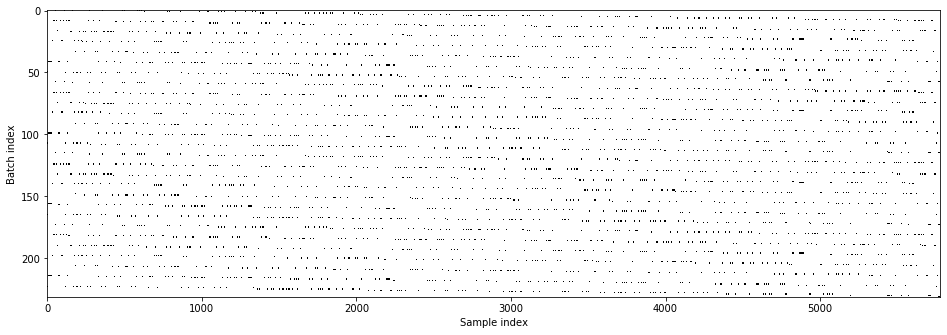

In [14]:
# First just list all file pathes to the sharded tfrecord dataset.
dataset = random1(train_path)

visualize_dataset(dataset)


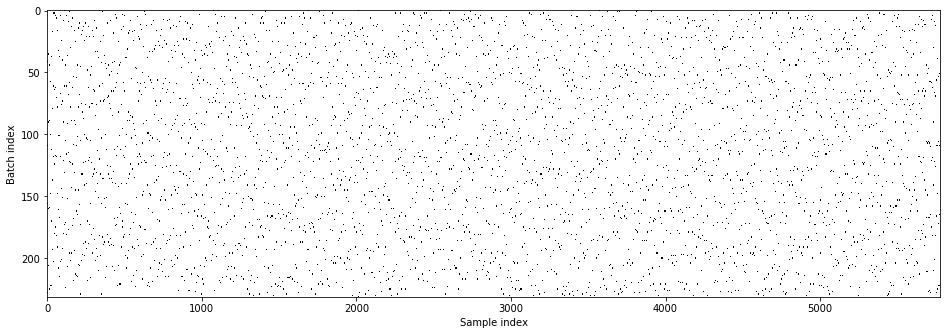

In [15]:
dataset = random2(train_path)

visualize_dataset(dataset)

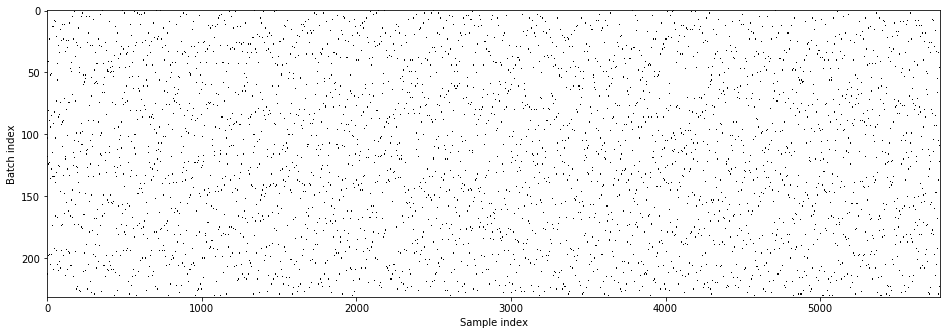

In [16]:
dataset = random3(train_path)

visualize_dataset(dataset)

tf.Tensor(b'data/training_WaterEdges-5-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-4-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-1-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-3-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-2-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-6-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-0-of-7.gz', shape=(), dtype=string)


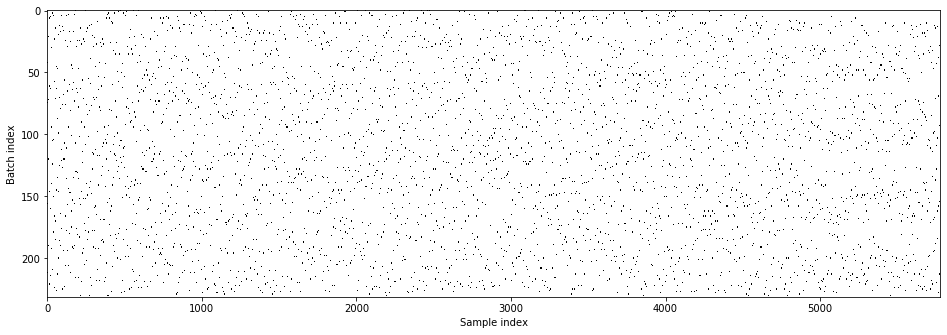

In [88]:
dataset = random4(train_path)

visualize_dataset(dataset)

### Conclusions on randomization

Obviously the first strategy is not the way to go. There is an obvious pattern throughout. The other 3 seem to work quite well, although the buffer size has to be tweaked to appropriate sizes. Finally, the interleaving method also has some issues besides tweaking the cycle and block parameters. If the number of shards is small, then the randomization suffers from it as well, and it might not be a good idea to use interleaving.

## Model training
The previous sections have treated basic handling of TFRecords and data exploration. Now we want to focus on main goal of this notebook, which is creating a classifier that detects dams from satellite images. 

In [93]:
# Load the TFRecord file
dataset = random4(train_path)

print(dataset)

tf.Tensor(b'data/training_WaterEdges-5-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-2-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-1-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-0-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-3-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-6-of-7.gz', shape=(), dtype=string)
tf.Tensor(b'data/training_WaterEdges-4-of-7.gz', shape=(), dtype=string)
<DatasetV1Adapter shapes: ((?, 257, 257, 3), (?, 1)), types: (tf.float32, tf.float32)>


In [94]:
inputs = tf.keras.Input(shape=(257,257,3, ))
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Flatten()(x)
predictions = layers.Dense(1, activation='softmax')(x)

model = tf.keras.Model(inputs = inputs, outputs=predictions)

model.compile(optimizer=tf.train.RMSPropOptimizer(0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

model.fit(dataset, epochs=5, steps_per_epoch=30, shuffle=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 257, 257, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 257, 257, 64)      256       
_________________________________________________________________
dense_1 (Dense)              (None, 257, 257, 64)      4160      
_________________________________________________________________
flatten (Flatten)            (None, 4227136)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4227137   
Total params: 4,231,553
Trainable params: 4,231,553
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5


W0901 13:54:21.936986 47925025625152 deprecation.py:323] From /vol/tensusers/sdooper/anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


30/30 [==============================] - 22s 740ms/step - loss: 1.0808e-07 - acc: 0.9067
Epoch 2/5
30/30 [==============================] - 16s 549ms/step - loss: 1.0351e-07 - acc: 0.8683
Epoch 3/5
30/30 [==============================] - 16s 549ms/step - loss: 1.0677e-07 - acc: 0.8957
Epoch 4/5
30/30 [==============================] - 16s 550ms/step - loss: 1.0482e-07 - acc: 0.8793
Epoch 5/5
30/30 [==============================] - 16s 548ms/step - loss: 1.0649e-07 - acc: 0.8933


## Testing and doodling area

In [49]:
# how do tuples work again

dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 8])

print(dataset.reduce(0, lambda state, value: value).numpy())


8


## TODO list 26/08/2019
Current to do list is cut into several aspect, namely at the data (implementation), implementation, and reporting areas.
The current version uses the following named data assets (on my personal google account).
1. GRanD_dams_v1_3: A shapefile with near locations of large dams, according to the GRanD v1.3. dataset, which can be found [here](http://globaldamwatch.org/grand/)
2. NoDams: coordinates of locations without dams, but near water bodies. 


### Data

The current dataset as of 23/08/2019 (Google Drive) contains the GRanD v 1.3. dams examples that serve as the positive labels for dam examples, as well as negative examples with samples that are located near water bodies. 
The following things come to mind to extend the dataset:

1. ***Extend non dam examples***: Adding more negative examples such as bridges, more locations near or in water bodies, dense forests, shiny roads, etc. 
2. ***Extend dam examples***: Adding more dam examples can be done by adding the locations of smaller dams, which can be found [here](http://globaldamwatch.org/).
3. ***NDVI data analysis***: A possible way to determine the effect of placing a dam on biodiversity could be to calculate the NDVI in the region before and after a dam was placed, and determine the difference in trend.
4. ***Segmentation/ gold standard labelling***: Several tools exists to create segmentation data which is more valuable. The downside is that it is a lot of manual labour, and multiple people are needed to create annotator agreement examples are [labelbox](https://labelbox.com/), which is a hosted service, or several labelling programs that can be run on your own server and are similar to labelbox, such as [labelme](https://github.com/wkentaro/labelme) or [labeltool](https://github.com/Slava/label-tool). 

### Implementation

The current implementation consists mainly of an experimental pipeline which has to be extended and optimized. The main focus lies on efficient data handling, an augmentation pipeline, reproducibility, and (readable) result creation in the form of graphs and metrics from which inference can be made.

1. ~~***Move data and scripts to server (Ponyland cluster)*** : self explanatory, make use of the more powerful GPU than on my local machine.~~
2. ***Data augmentation pipeline*** :The current implementation does not have any data augmentation. The fact that we are working with TFRecord can make it more difficult to work with data augmentations since no generators with predefined transformation are readily available.
3. ***Create abstract tuning/model pipeline***: Different classiers and neural network architectures will be tried and finetuned to find the best result. In order to prevent writing a lot of repeated code in many different files, a pipeline will be made from which models can be defined, finetuned, and executed.

***Optional***
1. ***Create a tensorboard/omniboard instance***
2. ***upgrade to TF 2.0*** : working with tf 2.0 seems less of a hassle, but could be done in spare time. The above of creating a tensorboard instance is natively implemented in notebooks then as well.


### Report

## Errors and troubles during pipeline creation

Ofcourse we encountered several difficulties that had to be overcome. In this section we will cover several of these and how these were solved:

1. **Dark images** (in Python): In the notebook we already explained that the way RGB bands google earth engine do not natively render well in Python. In fact, the RGB bands mostly appeared to be in the range of $RGB \in [0,0.2]$. Python ofcourse expects something normalized, or in the range of 0 to 255. We fixed this by casting the values to the range of $[0,255]$ and by forcing the highest pixel value across all bands to have a value of 255. This way, the colorspace was stretched and the images appeared to be much brighter (normal). 

2. **TFRecord errors**: The TFRecord datasets throw several errors. The first one we encountered was the outOfRange error, which simply meant the end of the record had been reached. As this is not an 'actual' error, we ignored this and simply catched the error if necessarry. The second error proved more difficult: when we were first iterating over a larger dataset we had the following InvalidArgumentError:      
   Feature: B2 (data type: float) is required but could not be found. [[{{node ParseSingleExample/ParseSingleExample}}]] [Op:IteratorGetNextSync].   
This meant that for some reason, one of our patches/examples did not have the compulsory B2 band as a data array. At first, this seemed rather arbitrary, since we surely exported this feature. However when plotting the B2 layer on the earth engine map using Map.addLayer(), we found that a large area in china with dams were masked, meaning that there was no information on the B2 layer present, and therefore not exported! We fixed this by setting a larger time period for the Sentinel 2 imageCollection from 2019-01-01 2019-05-01 to a year and a half:  2018-01-01 2019-05-01. 

3. **Exporting data tables in EE**: One of the more frustrating constraints of Google Earth Engine was the limitations on exporting large tables to the drive. It appeared that our first approach using the SampleRegions function was not successful, since the following error was thrown: reduceRegions: computed value too large. Luckily this gave us a hint that sampleRegions was nothing more than a wrapper function for recudeRegions. The way to solve our problem was to use a map function in combination with the reduceRegion function, which does not time out on single examples, which is explained in more detail [in this google doc](https://developers.google.com/earth-engine/debugging#reduceregion-vs-reduceregions). Although it is not incredibly efficient, it does work.

4. **Sparse elevation data (dsm)**: This problem could have been part of the TFRecord errors along with the B2 band problem, but the problem on this band is so severe that it deserves its own bullet point. The DSM data is incredibly sparse and large regions, i.e. Scandinavia are masked, again around dam regions. TO DO: CONTINUE WRITING THIS AFTER SOLUTION IS MADE

5.  **TFRecord randomization and sharding**:
